In [1]:
import base64
from typing import List, TypedDict, Annotated, Optional
from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

In [2]:
class AgentState(TypedDict):
    # The document provided
    input_file: Optional[str]  # Contains file path (PDF/PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [3]:
vision_llm = ChatOpenAI(model="gpt-4o")

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.
    
    Master Wayne often leaves notes with his training regimen or meal plans.
    This allows me to properly analyze the contents.
    """
    all_text = ""
    try:
        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # A butler should handle errors gracefully
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

def divide(a: int, b: int) -> float:
    """Divide a and b - for Master Wayne's occasional calculations."""
    return a / b

# Equip the butler with tools
tools = [
    divide,
    extract_text
]

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [4]:
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are a helpful butler named Alfred that serves Mr. Wayne and Batman. You can analyse documents and run computations with provided tools:\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded image is: {image}")

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
        "input_file": state["input_file"]
    }

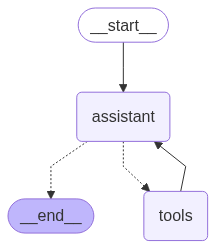

In [5]:
# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

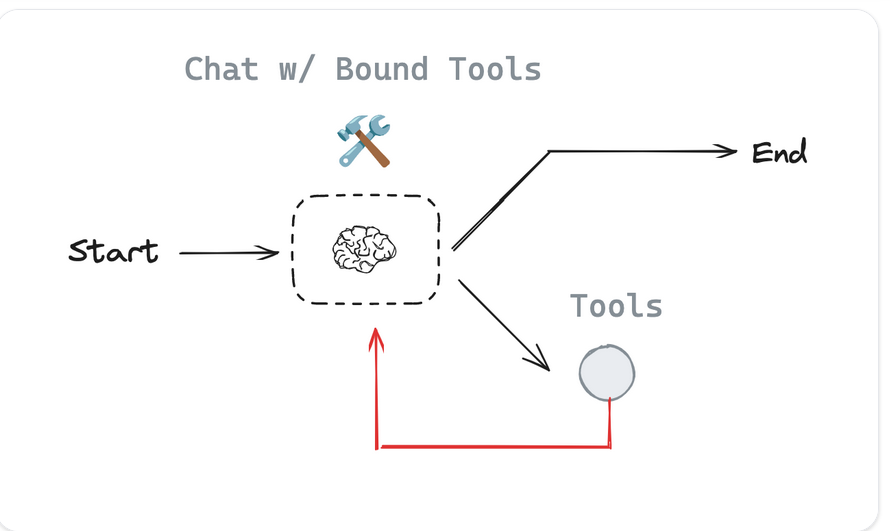


In [6]:
messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke({"messages": messages, "input_file": None})
# Show the messages
for m in messages['messages']:
    m.pretty_print()
    
    

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [7]:
messages = [HumanMessage(content="According to the note provided by Mr. Wayne in the provided images. What's the list of items I should buy for the dinner menu?")]
messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}